# 数据源与分析目的

- 数据源：https://tianchi.aliyun.com/dataset/146324?spm=a2c22.12282016.0.0.61bd29feSbzBvu

- 分析目标：基于物品的协同过滤算法，通过一个物品的相关数据，寻找与该物品相似的其他物品，为关注该物品的观众推荐相似物品。

# 读取数据

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

ratings = pd.read_csv(os.path.join(os.getcwd(), 'ratings.csv'))
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [3]:
books = pd.read_csv(os.path.join(os.getcwd(), 'books.csv'))
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [4]:
ratings.shape, books.shape

((5976479, 3), (10000, 23))

In [5]:
print(books['book_id'].isnull().sum())
print(books['title'].isnull().sum())
print(books['original_title'].isnull().sum())

0
0
585


In [6]:
df = pd.merge(ratings, books[['book_id','title']], on='book_id')
df.head()

,user_id,book_id,rating,title
0,1,258,5,The Shadow of the Wind (The Cemetery of Forgot...
1,2,4081,4,I am Charlotte Simmons
2,2,260,5,How to Win Friends and Influence People
3,2,9296,5,The Drama of the Gifted Child: The Search for ...
4,2,2318,3,The Millionaire Next Door: The Surprising Secr...


# 探索性数据分析

In [7]:
ratings_mean_count = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings_mean_count['rating_counts'] = df.groupby('title')['rating'].count()
ratings_mean_count.sort_values('rating_counts', ascending=False, inplace=True)
ratings_mean_count.head()

,rating,rating_counts
title,,
"The Hunger Games (The Hunger Games, #1)",4.279707,22806
"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",4.351350,21850
To Kill a Mockingbird,4.329369,19088
"Twilight (Twilight, #1)",3.214341,16931
The Great Gatsby,3.772224,16604


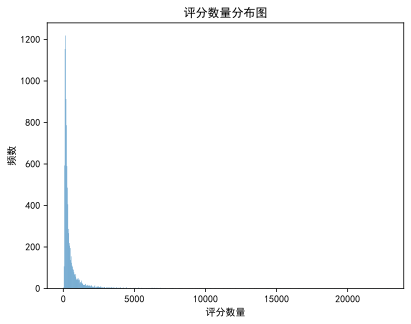

In [8]:
# 评分数量分布图
sns.histplot(ratings_mean_count['rating_counts'])
plt.xlabel('评分数量')
plt.ylabel('频数')
plt.title('评分数量分布图');

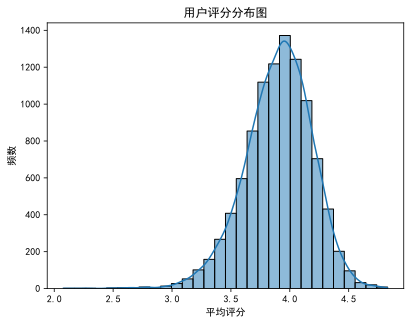

In [9]:
# 用户评分分布图
sns.histplot(ratings_mean_count['rating'], kde=True, bins=30)
plt.xlabel('平均评分')
plt.ylabel('频数')
plt.ticklabel_format(style='plain', axis='y')
plt.title('用户评分分布图');

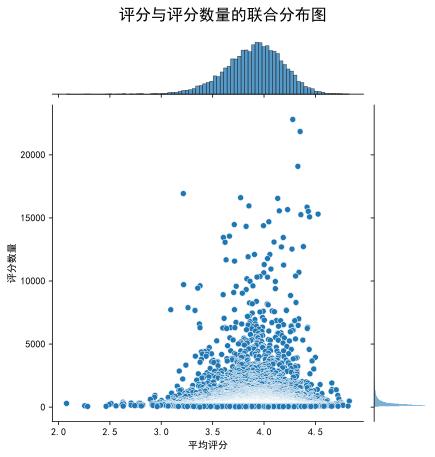

In [10]:
# 绘制双变量关系图
g = sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count)
g.set_axis_labels('平均评分', '评分数量')
g.fig.suptitle('评分与评分数量的联合分布图', fontsize=16, y=1.05);

可以看出每本书的评分数量集中在5000以下，书的评分集中在3.5-4.5分左右。

# 寻找书籍之间的相关性

In [11]:
# 由于数据多大，使用scipy.sparse创建稀疏矩阵，减少内存占用
from scipy.sparse import csr_matrix

# 映射 user_id 和 book_id 到数值索引
user_map = {u: i for i, u in enumerate(df['user_id'].unique())}  # 将 user_id 映射为行索引
book_map = {b: i for i, b in enumerate(df['title'].unique())}  # 将 book_id 映射为列索引

row = df['user_id'].map(user_map)  # 记录 user_id 在稀疏矩阵中的行号
col = df['title'].map(book_map)  # 记录 book_id 在稀疏矩阵中的列号
data = df['rating'].values  # 评分值（rating），存储在 (row, col) 位置

# 创建稀疏矩阵
sparse_matrix = csr_matrix((data, (row, col)))

print(sparse_matrix.shape)

(53424, 9964)


In [12]:
# 计算书籍之间的余弦相似度
from sklearn.metrics.pairwise import cosine_similarity

book_similarity = cosine_similarity(sparse_matrix.T)
book_similarity

array([[1.        , 0.03948567, 0.04167712, ..., 0.        , 0.        ,
        0.        ],
       [0.03948567, 1.        , 0.0148906 , ..., 0.        , 0.        ,
        0.        ],
       [0.04167712, 0.0148906 , 1.        , ..., 0.        , 0.        ,
        0.00355532],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.2049359 ,
        0.27871135],
       [0.        , 0.        , 0.        , ..., 0.2049359 , 1.        ,
        0.20207569],
       [0.        , 0.        , 0.00355532, ..., 0.27871135, 0.20207569,
        1.        ]])

In [18]:
# 基于书籍的推荐
def recommend_similar_books(title, sparse_matrix, book_similarity, top_n=10):
    # 找到书籍的索引
    book_idx = book_map[title]

    # 获取相似度矩阵中书籍对应的行
    similar_books = book_similarity[book_idx]

    # 选择最相似的前n本书的索引（不包含自身）
    similar_books_idx = np.argsort(similar_books)[::-1][1:top_n+1]

    return [list(book_map.keys())[i] for i in similar_books_idx]

In [17]:
# 获取与I am Charlotte Simmons书籍最相似的前10本书
recommend_similar_books('I am Charlotte Simmons', sparse_matrix, book_similarity, top_n=10)

['A Man in Full',
 'The Bonfire of the Vanities',
 'Prep',
 'The Electric Kool-Aid Acid Test',
 'The Corrections',
 'Middlesex',
 'A Heartbreaking Work of Staggering Genius',
 'American Wife',
 "She's Come Undone",
 'The Great Gatsby']